<a href="https://colab.research.google.com/github/20hnu/machine_learning/blob/main/Processing_Sequences_Using_RNNs_and_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [3]:
tf.keras.utils.get_file(
   "ridership.tgz",
   "https://github.com/ageron/data/raw/main/ridership.tgz",
   cache_dir=".",
   extract =True
)

108512/108512 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


'./datasets/ridership.tgz'

In [4]:
import pandas as pd
from pathlib import Path


path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date","date_type","bus","rail","total"]
df = df.sort_values("date").set_index("date")

In [5]:
df.shape

(7701, 4)

U: sunday or other holiday \\
A: saturday \\
W: Weekdays

In [6]:
df[df.duplicated()]

,date_type,bus,rail,total
date,,,,
2011-10-01,A,701783,480889,1182672
2011-10-02,U,486409,344520,830929
2011-10-03,W,1091676,751034,1842710
2011-10-04,W,1090878,767029,1857907
2011-10-05,W,1083300,774142,1857442
...,...,...,...,...
2014-07-27,U,423806,403719,827525
2014-07-28,W,810122,730188,1540310
2014-07-29,W,810857,746646,1557503


In [7]:
df = df.drop("total",axis=1)
df = df.drop_duplicates()

In [8]:
df.shape

(7639, 3)

Lets look at the first few months of 2019
(note that pandas treats the range boundaries as inclusive):

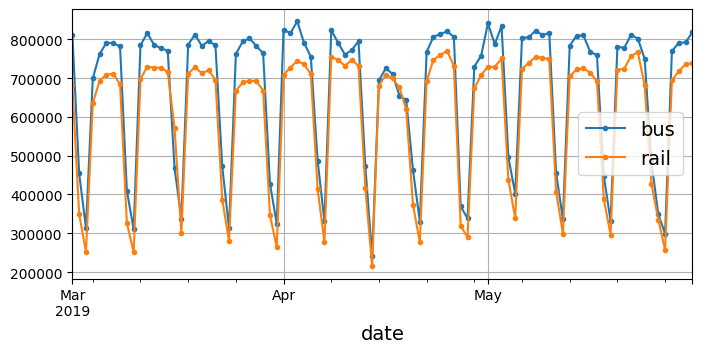

In [9]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8,3.5))
plt.show()

In [10]:
diff_7 = df[["bus","rail"]].diff(7)["2019-03":"2019-05"]

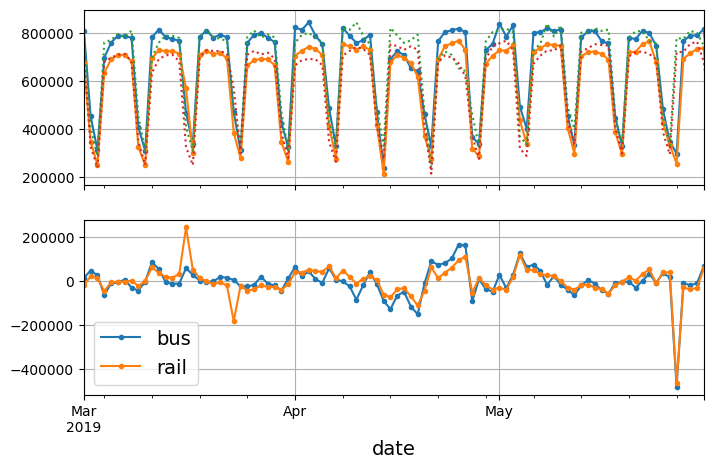

In [11]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])  # extra code – beautifies the plot
plt.show()

In [12]:
diff_7.sample(5)

,bus,rail
date,,
2019-04-07,6505.0,12764.0
2019-03-12,54448.0,36531.0
2019-04-09,-23814.0,20048.0
2019-05-14,3733.0,-16558.0
2019-03-22,14621.0,-20514.0


In [13]:
df.loc["2019-03-15"]

,2019-03-15
date_type,W
bus,769660
rail,716230


In [14]:
list(df.loc["2019-05-25":"2019-05-27"]["date_type"])

['A', 'U', 'U']

In [15]:
diff_7.head(7)

,bus,rail
date,,
2019-03-01,13927.0,-20019.0
2019-03-02,47280.0,21213.0
2019-03-03,25171.0,11672.0
2019-03-04,-63771.0,-45491.0
2019-03-05,-11268.0,-6517.0
2019-03-06,-6892.0,-2951.0
2019-03-07,6379.0,-3272.0


In [16]:
diff_7.abs().mean()

,0
bus,43915.608696
rail,42143.271739


In [17]:
targets = df[["bus","rail"]]["2019-03":"2019-05"]
(diff_7/targets).abs().mean()

,0
bus,0.082938
rail,0.089948


Now let's look at the yearly seasonality and the long-term trends:

In [18]:
df_changed= df.drop(columns="date_type")

In [19]:
df_changed.columns

Index(['bus', 'rail'], dtype='object')

<ipython-input-20-2b29e9404a04>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_changed.resample("M").mean()


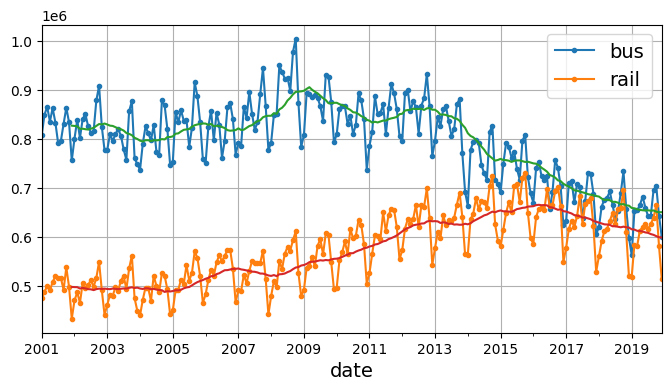

In [20]:
period = slice("2001","2019")
df_monthly = df_changed.resample("M").mean()
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()


fig,ax = plt.subplots(figsize=(8,4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

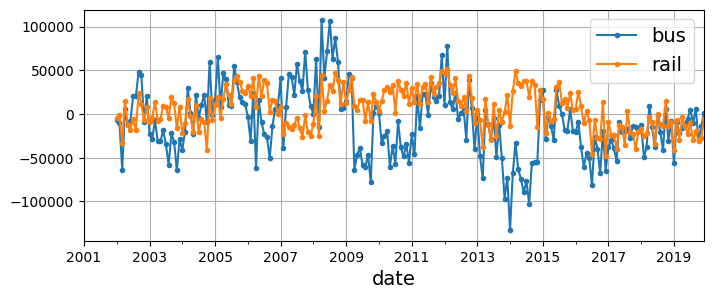

In [21]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8,3))
plt.show()


##ARIMA

In [22]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [23]:
def check_stationary(series):
  result = adfuller(series)
  print(f"ADF Statistic: {result[0]}")
  print(f"p-value: {result[1]}")
  if result[1] <= 0.05:
    print("Stationary")
  else:
    print("Non-stationary")

In [24]:
check_stationary(df["bus"].diff().dropna())

ADF Statistic: -20.6542816948684
p-value: 0.0
Stationary


In [25]:
check_stationary(df["rail"].diff().dropna())

ADF Statistic: -19.992318490576864
p-value: 0.0
Stationary


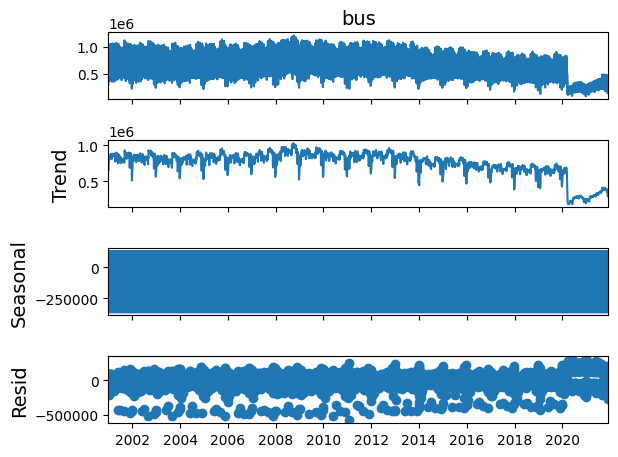

In [26]:
#seasonal decompose
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed = seasonal_decompose(df["bus"],model="additive")
decomposed.plot()
plt.show()

In [27]:
origin, today = "2019-01-01","2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series, order=(1,0,0),seasonal_order=(0,1,1,7))
model_fit = model.fit()
y_pred = model_fit.forecast()

In [28]:
y_pred

,0
2019-06-01,427758.62641


In [29]:
origin, start_date, end_date = "2019-01-01","2019-03-01","2019-05-31"
time_period = pd.date_range(start_date,end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds =[]
for today in time_period.shift(-1):
  model = ARIMA(rail_series[origin:today], order=(1,0,0),seasonal_order=(0,1,1,7))
  model_fit = model.fit()
  y_pred = model_fit.forecast()[0]
  y_preds.append(y_pred)

y_preds = pd.Series(y_preds,index=time_period)
mae = (y_preds-rail_series[time_period]).abs().mean()

<ipython-input-29-8bdb891fb077>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model_fit.forecast()[0]
<ipython-input-29-8bdb891fb077>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model_fit.forecast()[0]
<ipython-input-29-8bdb891fb077>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model_fit.forecast()[0]
<ipython-input-29-8bdb891fb077>:8: FutureWarning: Series.__getitem__ treating keys as position

In [30]:
mae

32040.720089453378

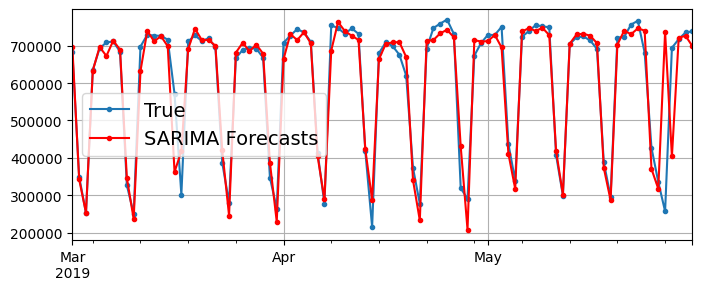

In [31]:
# extra code – displays the SARIMA forecasts
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")
plt.legend()
plt.show()

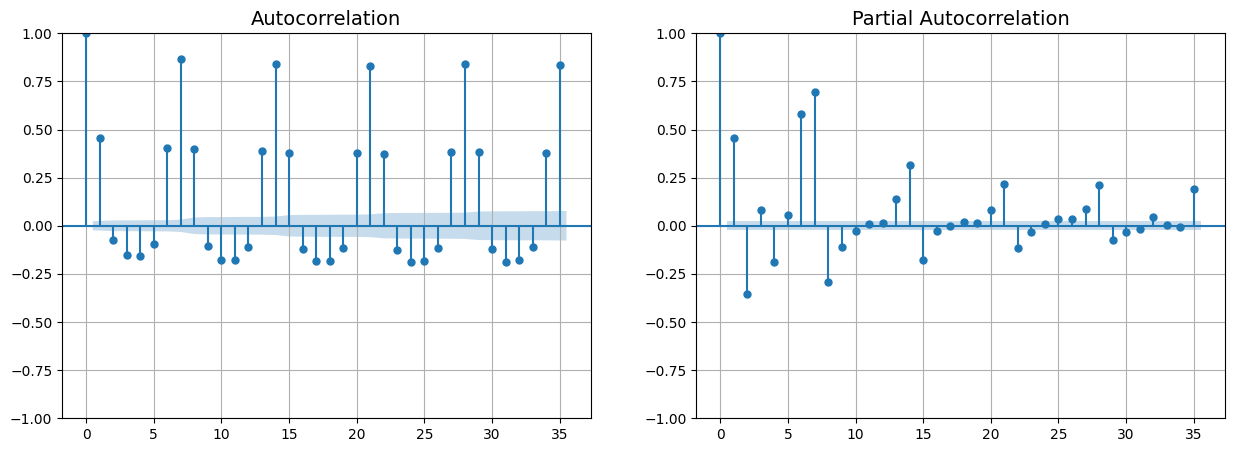

In [32]:
#shows how to plot the Autocorrelation Function (ACF) and the
#              Partial Autocorrelation Function (PACF)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axs = plt.subplots(figsize=(15,5),nrows=1,ncols=2)

plot_acf(df[period]["rail"],ax=axs[0],lags=35)
axs[0].grid()
plot_pacf(df[period]["rail"],ax=axs[1],lags=35)
axs[1].grid()
plt.show()



##understanding more about tensorflow

In [33]:
import tensorflow as tf

my_series = [0,1,2,3,4,5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(my_series, targets=my_series[3:],sequence_length=3,batch_size=2)


In [34]:
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

In [35]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


In [36]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
  print(f"{window_tensor}")


[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [37]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [38]:
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

In [39]:
df["rail"].tail(1)

,rail
date,
2021-11-30,302349


In [40]:
rail_train = df["rail"]["2016-01":"2018-12"]/1e6
rail_valid = df["rail"]["2019-01":"2019-05"]/1e6
rail_test = df["rail"]["2019-06":]/1e6

In [41]:
seq_length = 56
tf.random.set_seed(42)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

##Forecasting Using a Linear Model

In [42]:
tf.random.set_seed(42)
model= tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics= ["mae"])
history = model.fit(train_ds, validation_data=valid_ds,epochs=500, callbacks=[early_stopping_cb])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.2437 - mae: 0.5899 - val_loss: 0.0062 - val_mae: 0.0852
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0118 - mae: 0.1208 - val_loss: 0.0041 - val_mae: 0.0668
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0068 - mae: 0.0850 - val_loss: 0.0040 - val_mae: 0.0662
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0067 - mae: 0.0820 - val_loss: 0.0038 - val_mae: 0.0621
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - mae: 0.0805 - val_loss: 0.0039 - val_mae: 0.0661
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056 - mae: 0.0751 - val_loss: 0.0036 - val_mae: 0.0621
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - mae: 0.0730 - val_loss: 0.0032 - val_mae: 0.0557
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0054 - mae: 0.0727 - val_loss: 0.0032 - val_mae: 0.0553
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.00

In [43]:
# extra code – evaluates the model
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mae: 0.0387 


37298.25094342232

##Forecasting using simple RNN

In [44]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.Input(shape=(None, 1)),
    tf.keras.layers.SimpleRNN(1,return_sequences=True)
])

In [45]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [46]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)


Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - loss: 0.9670 - mae: 1.4505 - val_loss: 0.0494 - val_mae: 0.2581
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0507 - mae: 0.2585 - val_loss: 0.0459 - val_mae: 0.2446
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0323 - mae: 0.1836 - val_loss: 0.0192 - val_mae: 0.1483
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0197 - mae: 0.1684 - val_loss: 0.0190 - val_mae: 0.1473
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0189 - mae: 0.1622 - val_loss: 0.0189 - val_mae: 0.1463
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0185 - mae: 0.1600 - val_loss: 0.0188 - val_mae: 0.1454
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0184 - mae: 0.1616 - val_loss: 0.0185 - val_mae: 0.1451
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0193 - mae: 0.1658 - val_loss: 0.0185 - val_mae: 0.1438
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0

139583.63234996796

In [47]:
univar_model =tf.keras.Sequential([
    tf.keras.Input(shape=(None, 1)),
    tf.keras.layers.SimpleRNN(32,return_sequences=True),
    tf.keras.layers.Dense(1)
])

In [48]:
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)


Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.1005 - mae: 0.3335 - val_loss: 0.0207 - val_mae: 0.1280
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0198 - mae: 0.1650 - val_loss: 0.0159 - val_mae: 0.1517
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0172 - mae: 0.1614 - val_loss: 0.0160 - val_mae: 0.1471
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0177 - mae: 0.1624 - val_loss: 0.0159 - val_mae: 0.1604
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0185 - mae: 0.1670 - val_loss: 0.0158 - val_mae: 0.1566
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0182 - mae: 0.1647 - val_loss: 0.0168 - val_mae: 0.1362
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0185 - mae: 0.1617 - val_loss: 0.0158 - val_mae: 0.1492
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0182 - mae: 0.1639 - val_loss: 0.0160 - val_mae: 0.1628
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0

123630.8440566063

# Deep RNN

In [49]:
deep_model = tf.keras.Sequential([
    tf.keras.Input(shape=(None,1)),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [50]:
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - loss: 0.0254 - mae: 0.1782 - val_loss: 0.0086 - val_mae: 0.0920
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0091 - mae: 0.1078 - val_loss: 0.0079 - val_mae: 0.1065
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0064 - mae: 0.0830 - val_loss: 0.0024 - val_mae: 0.0504
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0047 - mae: 0.0681 - val_loss: 0.0024 - val_mae: 0.0499
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0048 - mae: 0.0646 - val_loss: 0.0024 - val_mae: 0.0486
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0046 - mae: 0.0643 - val_loss: 0.0022 - val_mae: 0.0443
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0047 - mae: 0.0630 - val_loss: 0.0022 - val_mae: 0.0419
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0052 - mae: 0.0666 - val_loss: 0.0030 - val_mae: 0.0531
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - lo

30953.070148825645

# Forecasting Multivariate Time Series

In [51]:
df_mulvar =  df[["bus","rail"]]/ 1e6
df_mulvar["next_day_type"] = df["date_type"].shift(-1)# we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar,dtype=int,columns=["next_day_type"])

In [52]:
df_mulvar.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7639 entries, 2001-01-01 to 2021-11-30
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bus              7639 non-null   float64
 1   rail             7639 non-null   float64
 2   next_day_type_A  7639 non-null   int64  
 3   next_day_type_U  7639 non-null   int64  
 4   next_day_type_W  7639 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 616.1 KB


In [53]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [54]:
mulvar_train.head()

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2016-01-01,0.303321,0.319835,1,0,0
2016-01-02,0.448859,0.365509,0,1,0
2016-01-03,0.340540,0.287661,0,0,1
2016-01-04,0.829429,0.703185,0,0,1
2016-01-05,0.846789,0.727716,0,0,1


In [55]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # use all 5 columns as input
    targets=mulvar_train["rail"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [56]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [57]:
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.2979 - mae: 0.6001 - val_loss: 0.0065 - val_mae: 0.0960
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0068 - mae: 0.0930 - val_loss: 0.0028 - val_mae: 0.0625
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0022 - mae: 0.0483 - val_loss: 0.0015 - val_mae: 0.0436
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0017 - mae: 0.0391 - val_loss: 0.0011 - val_mae: 0.0391
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0016 - mae: 0.0386 - val_loss: 0.0025 - val_mae: 0.0589
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0016 - mae: 0.0405 - val_loss: 9.5403e-04 - val_mae: 0.0329
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0014 - mae: 0.0365 - val_loss: 0.0015 - val_mae: 0.0428
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0015 - mae: 0.0390 - val_loss: 0.0010 - val_mae: 0.0373
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

22065.15334546566

# Two Forecasts from single model

In [58]:

tf.random.set_seed(42)

seq_length = 56
train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train[["bus", "rail"]][seq_length:],  # 2 targets per day
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

tf.random.set_seed(42)
multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2)
])

fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds,
                 learning_rate=0.02)

Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.1445 - mae: 0.4020 - val_loss: 0.0107 - val_mae: 0.1225
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0055 - mae: 0.0798 - val_loss: 9.7625e-04 - val_mae: 0.0318
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0020 - mae: 0.0463 - val_loss: 0.0013 - val_mae: 0.0393
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0019 - mae: 0.0427 - val_loss: 8.6437e-04 - val_mae: 0.0308
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0019 - mae: 0.0443 - val_loss: 0.0015 - val_mae: 0.0440
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0018 - mae: 0.0430 - val_loss: 7.8631e-04 - val_mae: 0.0284
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0018 - mae: 0.0417 - val_loss: 0.0010 - val_mae: 0.0338
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0018 - mae: 0.0419 - val_loss: 7.9795e-04 - val_mae: 0.0288
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step 

26813.805103302002

#Forecasting Several Time Steps Ahead

In [59]:
import numpy as np

X = rail_valid.to_numpy()[np.newaxis,:seq_length, np.newaxis]
for step_ahead in range(14):
  y_pred_one = univar_model.predict(X)
  X = np.concatenate([X, y_pred_one], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


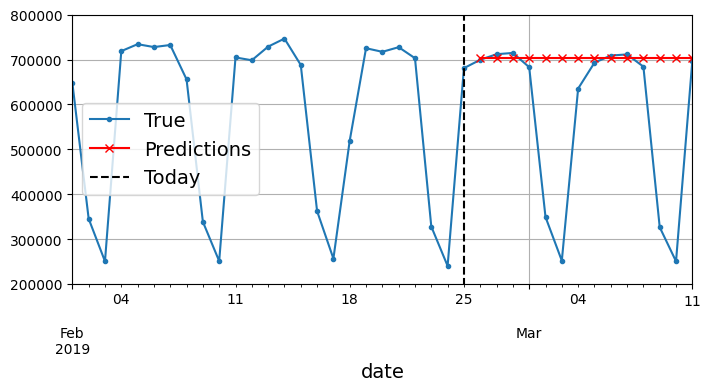

In [60]:
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
plt.show()

In [61]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [62]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [63]:
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.02)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.1456 - mae: 0.4179 - val_loss: 0.0249 - val_mae: 0.1794
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0202 - mae: 0.1609 - val_loss: 0.0122 - val_mae: 0.1243
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0132 - mae: 0.1297 - val_loss: 0.0097 - val_mae: 0.1088
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0110 - mae: 0.1167 - val_loss: 0.0081 - val_mae: 0.0991
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0096 - mae: 0.1074 - val_loss: 0.0068 - val_mae: 0.0906
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0087 - mae: 0.1008 - val_loss: 0.0060 - val_mae: 0.0850
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0081 - mae: 0.0962 - val_loss: 0.0056 - val_mae: 0.0819
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0073 - mae: 0.0903 - val_loss: 0.0048 - val_mae: 0.0753
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - los

33894.51652765274

#Forcasting using a seq-to-seq model

In [64]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]])>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]])>]

In [65]:
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]])>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]])>)]

In [66]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [67]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [68]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [69]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

Epoch 1/500
     33/Unknown 3s 30ms/step - loss: 0.1399 - mae: 0.3928

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.1376 - mae: 0.3886 - val_loss: 0.0172 - val_mae: 0.1409
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0126 - mae: 0.1256 - val_loss: 0.0104 - val_mae: 0.1071
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0091 - mae: 0.1050 - val_loss: 0.0084 - val_mae: 0.0954
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0079 - mae: 0.0954 - val_loss: 0.0077 - val_mae: 0.0878
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0069 - mae: 0.0866 - val_loss: 0.0069 - val_mae: 0.0813
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0062 - mae: 0.0803 - val_loss: 0.0060 - val_mae: 0.0735
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0057 - mae: 0.0757 - val_loss: 0.0059 - val_mae: 0.0736
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0052 - mae: 0.0706 - val_loss: 0.0054 - val_mae: 0.0688
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0048 -

47224.06342625618

In [70]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X)[0, -1]  # only the last time step's output

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


In [71]:
Y_pred_valid = seq2seq_model.predict(seq2seq_valid)
for ahead in range(14):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=mulvar_valid.index[56 + ahead : -14 + ahead])
    mae = (preds - mulvar_valid["rail"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step
MAE for +1: 24,968
MAE for +2: 28,186
MAE for +3: 31,647
MAE for +4: 32,473
MAE for +5: 32,709
MAE for +6: 34,661
MAE for +7: 33,890
MAE for +8: 33,164
MAE for +9: 32,949
MAE for +10: 32,828
MAE for +11: 37,925
MAE for +12: 37,150
MAE for +13: 34,937
MAE for +14: 35,058


#Deep RNNs with layer Norm

In [72]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units,
                                                             activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [73]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True,
                        input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [74]:
fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.1514 - mae: 0.4063 - val_loss: 0.0195 - val_mae: 0.1439
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0154 - mae: 0.1478 - val_loss: 0.0159 - val_mae: 0.1271
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0129 - mae: 0.1346 - val_loss: 0.0149 - val_mae: 0.1202
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0118 - mae: 0.1255 - val_loss: 0.0133 - val_mae: 0.1154
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0109 - mae: 0.1196 - val_loss: 0.0123 - val_mae: 0.1101
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0133 - mae: 0.1135


110149.18237924576

#LSTM

In [75]:
tf.random.set_seed(42)
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [76]:
# fit_and_evaluate(model, seq2seq_train, seq2seq_valid, learning_rate=0.1,epochs=5)

#GRU

In [77]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [78]:
fit_and_evaluate(gru_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.1042 - mae: 0.3626 - val_loss: 0.0178 - val_mae: 0.1564
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0159 - mae: 0.1473 - val_loss: 0.0149 - val_mae: 0.1306
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0126 - mae: 0.1297 - val_loss: 0.0134 - val_mae: 0.1232
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0115 - mae: 0.1222 - val_loss: 0.0122 - val_mae: 0.1192
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0107 - mae: 0.1180 - val_loss: 0.0116 - val_mae: 0.1153
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0125 - mae: 0.1186


115306.63073062897

#Using One-Dimensional Convolutional Layers to Process Sequences

In [79]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation="relu", input_shape=[None, 5]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112,
                                       shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid, seq_length=112)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [80]:
fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
     31/Unknown 3s 12ms/step - loss: 0.0995 - mae: 0.3632

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0981 - mae: 0.3598 - val_loss: 0.0207 - val_mae: 0.1510
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0166 - mae: 0.1509 - val_loss: 0.0162 - val_mae: 0.1403
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0138 - mae: 0.1403 - val_loss: 0.0146 - val_mae: 0.1311
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0121 - mae: 0.1307 - val_loss: 0.0129 - val_mae: 0.1216
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0106 - mae: 0.1196 - val_loss: 0.0114 - val_mae: 0.1123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0114 - mae: 0.1123


112307.86144733429

#WaveNet


In [81]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.InputLayer(input_shape=[None, 5]))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(
        filters=32, kernel_size=2, padding="causal", activation="relu",
        dilation_rate=rate))
wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [82]:
fit_and_evaluate(wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - loss: 0.1339 - mae: 0.4503 - val_loss: 0.0217 - val_mae: 0.1679
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0175 - mae: 0.1618 - val_loss: 0.0183 - val_mae: 0.1539
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0158 - mae: 0.1572 - val_loss: 0.0178 - val_mae: 0.1503
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0151 - mae: 0.1540 - val_loss: 0.0171 - val_mae: 0.1458
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0143 - mae: 0.1483 - val_loss: 0.0158 - val_mae: 0.1382
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0158 - mae: 0.1382


138236.32895946503

#Exercise Solutions

1. Here are a few RNN applications:
    * For a sequence-to-sequence RNN: predicting the weather (or any other time series), machine translation (using an Encoder–Decoder architecture), video captioning, speech to text, music generation (or other sequence generation), identifying the chords of a song
    * For a sequence-to-vector RNN: classifying music samples by music genre, analyzing the sentiment of a book review, predicting what word an aphasic patient is thinking of based on readings from brain implants, predicting the probability that a user will want to watch a movie based on their watch history (this is one of many possible implementations of _collaborative filtering_ for a recommender system)
    * For a vector-to-sequence RNN: image captioning, creating a music playlist based on an embedding of the current artist, generating a melody based on a set of parameters, locating pedestrians in a picture (e.g., a video frame from a self-driving car's camera)
2. An RNN layer must have three-dimensional inputs: the first dimension is the batch dimension (its size is the batch size), the second dimension represents the time (its size is the number of time steps), and the third dimension holds the inputs at each time step (its size is the number of input features per time step). For example, if you want to process a batch containing 5 time series of 10 time steps each, with 2 values per time step (e.g., the temperature and the wind speed), the shape will be [5, 10, 2]. The outputs are also three-dimensional, with the same first two dimensions, but the last dimension is equal to the number of neurons. For example, if an RNN layer with 32 neurons processes the batch we just discussed, the output will have a shape of [5, 10, 32].
3. To build a deep sequence-to-sequence RNN using Keras, you must set `return_sequences=True` for all RNN layers. To build a sequence-to-vector RNN, you must set `return_sequences=True` for all RNN layers except for the top RNN layer, which must have `return_sequences=False` (or do not set this argument at all, since `False` is the default).
4. If you have a daily univariate time series, and you want to forecast the next seven days, the simplest RNN architecture you can use is a stack of RNN layers (all with `return_sequences=True` except for the top RNN layer), using seven neurons in the output RNN layer. You can then train this model using random windows from the time series (e.g., sequences of 30 consecutive days as the inputs, and a vector containing the values of the next 7 days as the target). This is a sequence-to-vector RNN. Alternatively, you could set `return_sequences=True` for all RNN layers to create a sequence-to-sequence RNN. You can train this model using random windows from the time series, with sequences of the same length as the inputs as the targets. Each target sequence should have seven values per time step (e.g., for time step _t_, the target should be a vector containing the values at time steps _t_ + 1 to _t_ + 7).
5. The two main difficulties when training RNNs are unstable gradients (exploding or vanishing) and a very limited short-term memory. These problems both get worse when dealing with long sequences. To alleviate the unstable gradients problem, you can use a smaller learning rate, use a saturating activation function such as the hyperbolic tangent (which is the default), and possibly use gradient clipping, Layer Normalization, or dropout at each time step. To tackle the limited short-term memory problem, you can use `LSTM` or `GRU` layers (this also helps with the unstable gradients problem).
6. An LSTM cell's architecture looks complicated, but it's actually not too hard if you understand the underlying logic. The cell has a short-term state vector and a long-term state vector. At each time step, the inputs and the previous short-term state are fed to a simple RNN cell and three gates: the forget gate decides what to remove from the long-term state, the input gate decides which part of the output of the simple RNN cell should be added to the long-term state, and the output gate decides which part of the long-term state should be output at this time step (after going through the tanh activation function). The new short-term state is equal to the output of the cell. See Figure 15–12.
7. An RNN layer is fundamentally sequential: in order to compute the outputs at time step _t_, it has to first compute the outputs at all earlier time steps. This makes it impossible to parallelize. On the other hand, a 1D convolutional layer lends itself well to parallelization since it does not hold a state between time steps. In other words, it has no memory: the output at any time step can be computed based only on a small window of values from the inputs without having to know all the past values. Moreover, since a 1D convolutional layer is not recurrent, it suffers less from unstable gradients. One or more 1D convolutional layers can be useful in an RNN to efficiently preprocess the inputs, for example to reduce their temporal resolution (downsampling) and thereby help the RNN layers detect long-term patterns. In fact, it is possible to use only convolutional layers, for example by building a WaveNet architecture.
8. To classify videos based on their visual content, one possible architecture could be to take (say) one frame per second, then run every frame through the same convolutional neural network (e.g., a pretrained Xception model, possibly frozen if your dataset is not large), feed the sequence of outputs from the CNN to a sequence-to-vector RNN, and finally run its output through a softmax layer, giving you all the class probabilities. For training you would use cross entropy as the cost function. If you wanted to use the audio for classification as well, you could use a stack of strided 1D convolutional layers to reduce the temporal resolution from thousands of audio frames per second to just one per second (to match the number of images per second), and concatenate the output sequence to the inputs of the sequence-to-vector RNN (along the last dimension).

_Exercise: Train a classification model for the SketchRNN dataset, available in TensorFlow Datasets._

The dataset is not available in TFDS yet, the [pull request](https://github.com/tensorflow/datasets/pull/361) is still work in progress. Luckily, the data is conveniently available as TFRecords, so let's download it (it might take a while, as it's about 1 GB large, with 3,450,000 training sketches and 345,000 test sketches):

In [83]:
tf_download_root = 'http://download.tensorflow.org/data/'
filename = "quickdraw_tutorial_dataset_v1.tar.gz"
file_path = tf.keras.utils.get_file(
    fname=filename,
    origin=tf_download_root + filename,
    cache_dir=".",
    extract=True
)

1065301781/1065301781 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step


In [84]:
quickdraw_dir = Path(file_path).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

In [85]:
train_files

['datasets/training.tfrecord-00000-of-00010',
 'datasets/training.tfrecord-00001-of-00010',
 'datasets/training.tfrecord-00002-of-00010',
 'datasets/training.tfrecord-00003-of-00010',
 'datasets/training.tfrecord-00004-of-00010',
 'datasets/training.tfrecord-00005-of-00010',
 'datasets/training.tfrecord-00006-of-00010',
 'datasets/training.tfrecord-00007-of-00010',
 'datasets/training.tfrecord-00008-of-00010',
 'datasets/training.tfrecord-00009-of-00010']

In [86]:
eval_files

['datasets/eval.tfrecord-00000-of-00010',
 'datasets/eval.tfrecord-00001-of-00010',
 'datasets/eval.tfrecord-00002-of-00010',
 'datasets/eval.tfrecord-00003-of-00010',
 'datasets/eval.tfrecord-00004-of-00010',
 'datasets/eval.tfrecord-00005-of-00010',
 'datasets/eval.tfrecord-00006-of-00010',
 'datasets/eval.tfrecord-00007-of-00010',
 'datasets/eval.tfrecord-00008-of-00010',
 'datasets/eval.tfrecord-00009-of-00010']

In [87]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()

with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [88]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [89]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [90]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [91]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [92]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [93]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[-0.0944882  -0.04663213  0.        ]
  [-0.08661417  0.04145078  0.        ]
  [-0.03937007  0.05181348  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.04313726 -0.14960629  0.        ]
  [ 0.06274509 -0.40551183  0.        ]
  [ 0.04313726 -0.12598425  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.          0.          1.        ]
  [ 0.          0.          0.        ]
  [-0.19607842 -0.03174603  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[-0.12790698  0.01960784  0.        ]
  [-0.02906978  0.2117647   0.        ]
  [-0.04651159  0.06274509  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

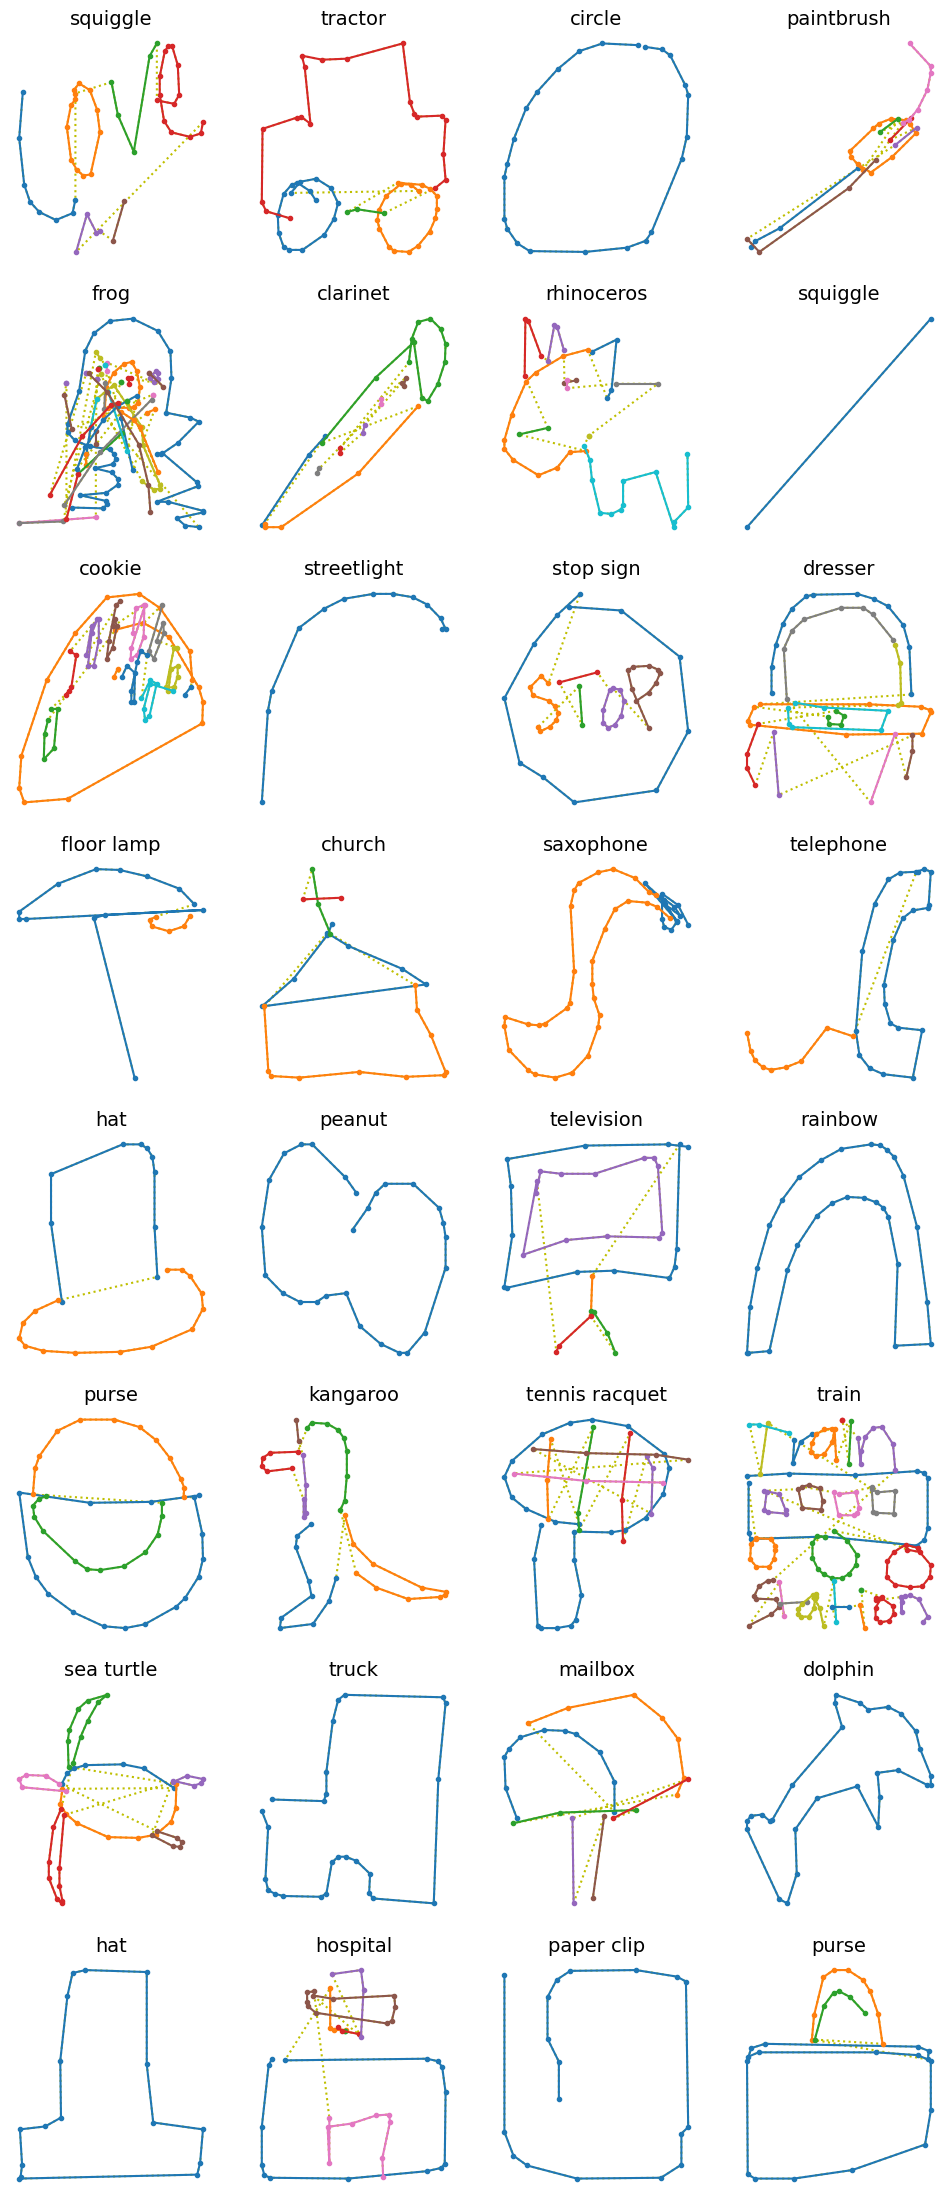

In [94]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = sketch[:, :2].cumsum(axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

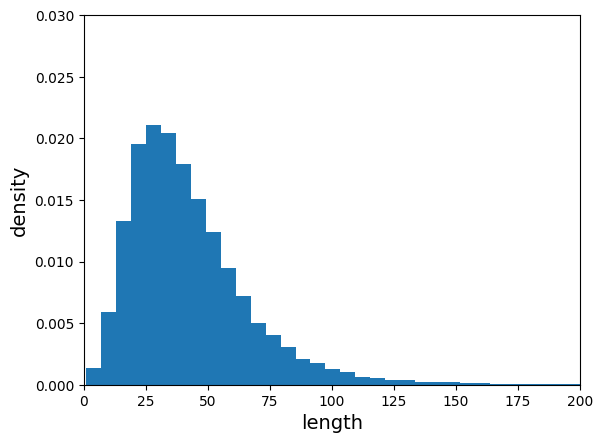

In [95]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [96]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, kernel_size=5,strides=2,activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(64, kernel_size=5,strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(128, kernel_size=3, strides=2,activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(128,return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(len(class_names),activation="softmax")
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy", optimizer = optimizer, metrics=["accuracy","sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=2, validation_data=cropped_valid_set )

Epoch 1/2
107813/107813 ━━━━━━━━━━━━━━━━━━━━ 986s 9ms/step - accuracy: 0.0767 - loss: 4.8769 - sparse_top_k_categorical_accuracy: 0.1989 - val_accuracy: 0.2921 - val_loss: 3.1710 - val_sparse_top_k_categorical_accuracy: 0.5738
Epoch 2/2
 50300/107813 ━━━━━━━━━━━━━━━━━━━━ 8:28 9ms/step - accuracy: 0.3292 - loss: 2.9755 - sparse_top_k_categorical_accuracy: 0.6164

In [ ]:
y_test = np.concatenate([labels for _,_,labels in test_set])
y_probas = model.predict(test_set)

In [ ]:
for features, labels in cropped_train_set.take(1):
    print("Features:", features)
    print("Labels:", labels)

In [ ]:
np.mean(tf.keras.metrics.sparse_top_k_categorical_accuracy(y_test,y_probas))

In [ ]:
n_new =10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k= 5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))

## 10. Bach Chorales
_Exercise: Download the [Bach chorales](https://homl.info/bach) dataset and unzip it. It is composed of 382 chorales composed by Johann Sebastian Bach. Each chorale is 100 to 640 time steps long, and each time step contains 4 integers, where each integer corresponds to a note's index on a piano (except for the value 0, which means that no note is played). Train a model—recurrent, convolutional, or both—that can predict the next time step (four notes), given a sequence of time steps from a chorale. Then use this model to generate Bach-like music, one note at a time: you can do this by giving the model the start of a chorale and asking it to predict the next time step, then appending these time steps to the input sequence and asking the model for the next note, and so on. Also make sure to check out [Google's Coconet model](https://homl.info/coconet), which was used for a nice [Google doodle about Bach](https://www.google.com/doodles/celebrating-johann-sebastian-bach)._



In [ ]:
tf.keras.utils.get_file(
    "jsb_chorales.tgz",
    "https://github.com/ageron/data/raw/main/jsb_chorales.tgz",
    cache_dir=".",
    extract=True)

In [ ]:
jsb_chorales_dir = Path("datasets/jsb_chorales")
train_files = sorted(jsb_chorales_dir.glob("train/chorale_*.csv"))
valid_files = sorted(jsb_chorales_dir.glob("valid/chorale_*.csv"))
test_files = sorted(jsb_chorales_dir.glob("test/chorale_*.csv"))

In [ ]:
import pandas as pd

def load_chorales(filepaths):
    return [pd.read_csv(filepath).values.tolist() for filepath in filepaths]

train_chorales = load_chorales(train_files)
valid_chorales = load_chorales(valid_files)
test_chorales = load_chorales(test_files)

In [ ]:
notes = set()
for chorales in (train_chorales, valid_chorales, test_chorales):
    for chorale in chorales:
        for chord in chorale:
            notes |= set(chord)

n_notes = len(notes)
min_note = min(notes - {0})
max_note = max(notes)

assert min_note == 36
assert max_note == 81

In [ ]:
from IPython.display import Audio

def notes_to_frequencies(notes):
    # Frequency doubles when you go up one octave; there are 12 semi-tones
    # per octave; Note A on octave 4 is 440 Hz, and it is note number 69.
    return 2 ** ((np.array(notes) - 69) / 12) * 440

def frequencies_to_samples(frequencies, tempo, sample_rate):
    note_duration = 60 / tempo # the tempo is measured in beats per minutes
    # To reduce click sound at every beat, we round the frequencies to try to
    # get the samples close to zero at the end of each note.
    frequencies = (note_duration * frequencies).round() / note_duration
    n_samples = int(note_duration * sample_rate)
    time = np.linspace(0, note_duration, n_samples)
    sine_waves = np.sin(2 * np.pi * frequencies.reshape(-1, 1) * time)
    # Removing all notes with frequencies ≤ 9 Hz (includes note 0 = silence)
    sine_waves *= (frequencies > 9.).reshape(-1, 1)
    return sine_waves.reshape(-1)

def chords_to_samples(chords, tempo, sample_rate):
    freqs = notes_to_frequencies(chords)
    freqs = np.r_[freqs, freqs[-1:]] # make last note a bit longer
    merged = np.mean([frequencies_to_samples(melody, tempo, sample_rate)
                     for melody in freqs.T], axis=0)
    n_fade_out_samples = sample_rate * 60 // tempo # fade out last note
    fade_out = np.linspace(1., 0., n_fade_out_samples)**2
    merged[-n_fade_out_samples:] *= fade_out
    return merged

def play_chords(chords, tempo=160, amplitude=0.1, sample_rate=44100, filepath=None):
    samples = amplitude * chords_to_samples(chords, tempo, sample_rate)
    if filepath:
        from scipy.io import wavfile
        samples = (2**15 * samples).astype(np.int16)
        wavfile.write(filepath, sample_rate, samples)
        return display(Audio(filepath))
    else:
        return display(Audio(samples, rate=sample_rate))

In [ ]:
for index in range(3):
    play_chords(train_chorales[index])

In order to be able to generate new chorales, we want to train a model that can predict the next chord given all the previous chords. If we naively try to predict the next chord in one shot, predicting all 4 notes at once, we run the risk of getting notes that don't go very well together (believe me, I tried). It's much better and simpler to predict one note at a time. So we will need to preprocess every chorale, turning each chord into an arpegio (i.e., a sequence of notes rather than notes played simultaneuously). So each chorale will be a long sequence of notes (rather than chords), and we can just train a model that can predict the next note given all the previous notes. We will use a sequence-to-sequence approach, where we feed a window to the neural net, and it tries to predict that same window shifted one time step into the future.

We will also shift the values so that they range from 0 to 46, where 0 represents silence, and values 1 to 46 represent notes 36 (C1) to 81 (A5).

And we will train the model on windows of 128 notes (i.e., 32 chords).

Since the dataset fits in memory, we could preprocess the chorales in RAM using any Python code we like, but I will demonstrate here how to do all the preprocessing using tf.data (there will be more details about creating windows using tf.data in the next chapter).

In [ ]:
def create_target(batch):
    X = batch[:, :-1]
    Y = batch[:, 1:] # predict next note in each arpegio, at each step
    return X, Y

def preprocess(window):
    window = tf.where(window == 0, window, window - min_note + 1) # shift values
    return tf.reshape(window, [-1]) # convert to arpegio

def bach_dataset(chorales, batch_size=32, shuffle_buffer_size=None,
                 window_size=32, window_shift=16, cache=True):
    def batch_window(window):
        return window.batch(window_size + 1)

    def to_windows(chorale):
        dataset = tf.data.Dataset.from_tensor_slices(chorale)
        dataset = dataset.window(window_size + 1, window_shift, drop_remainder=True)
        return dataset.flat_map(batch_window)

    chorales = tf.ragged.constant(chorales, ragged_rank=1)
    dataset = tf.data.Dataset.from_tensor_slices(chorales)
    dataset = dataset.flat_map(to_windows).map(preprocess)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(create_target)
    return dataset.prefetch(1)

In [ ]:
train_set = bach_dataset(train_chorales, shuffle_buffer_size=1000)
valid_set = bach_dataset(valid_chorales)
test_set = bach_dataset(test_chorales)

Now let's create the model:

* We could feed the note values directly to the model, as floats, but this would probably not give good results. Indeed, the relationships between notes are not that simple: for example, if you replace a C3 with a C4, the melody will still sound fine, even though these notes are 12 semi-tones apart (i.e., one octave). Conversely, if you replace a C3 with a C\#3, it's very likely that the chord will sound horrible, despite these notes being just next to each other. So we will use an `Embedding` layer to convert each note to a small vector representation (see Chapter 16 for more details on embeddings). We will use 5-dimensional embeddings, so the output of this first layer will have a shape of `[batch_size, window_size, 5]`.
* We will then feed this data to a small WaveNet-like neural network, composed of a stack of 4 `Conv1D` layers with doubling dilation rates. We will intersperse these layers with `BatchNormalization` layers for faster better convergence.
* Then one `LSTM` layer to try to capture long-term patterns.
* And finally a `Dense` layer to produce the final note probabilities. It will predict one probability for each chorale in the batch, for each time step, and for each possible note (including silence). So the output shape will be `[batch_size, window_size, 47]`.

In [ ]:
n_embedding_dims = 5

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_notes, output_dim=n_embedding_dims,
                           input_shape=[None]),
    tf.keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.Dense(n_notes, activation="softmax")
])

model.summary()

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
model.fit(train_set, epochs=20, validation_data=valid_set)

In [ ]:
model.save("my_bach_model", save_format="tf")
model.evaluate(test_set)

In [ ]:
def generate_chorale(model, seed_chords, length):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            next_note = model.predict(arpegio, verbose=0).argmax(axis=-1)[:1, -1:]
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

In [ ]:
seed_chords = test_chorales[2][:8]
play_chords(seed_chords, amplitude=0.2)

In [ ]:
new_chorale = generate_chorale(model, seed_chords, 56)
play_chords(new_chorale)

In [ ]:
def generate_chorale_v2(model, seed_chords, length, temperature=1):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            next_note_probas = model.predict(arpegio)[0, -1:]
            rescaled_logits = tf.math.log(next_note_probas) / temperature
            next_note = tf.random.categorical(rescaled_logits, num_samples=1)
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

In [ ]:
new_chorale_v2_cold = generate_chorale_v2(model, seed_chords, 56, temperature=0.8)
play_chords(new_chorale_v2_cold, filepath="bach_cold.wav")

In [ ]:
new_chorale_v2_medium = generate_chorale_v2(model, seed_chords, 56, temperature=1.0)
play_chords(new_chorale_v2_medium, filepath="bach_medium.wav")

In [ ]:
new_chorale_v2_hot = generate_chorale_v2(model, seed_chords, 56, temperature=1.5)
play_chords(new_chorale_v2_hot, filepath="bach_hot.wav")

In [ ]:
play_chords(test_chorales[2][:64], filepath="bach_test_4.wav")